# Step 7： Data Mining

# Logistic Regression

In [1]:

# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DBAS-Step7-DM-LogisticRegression').getOrCreate()

# Enable pandas-on-Spark
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 23:48:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
## Load data from csv file
spk_df = spark.read.csv("Data/4DT/heart_failure_dataset_4DT.csv", header=True, inferSchema=True)
spk_df.printSchema

# Convert Spark DataFrame to pandas-on-Spark DataFrame using to_pandas_on_spark()
spkpd_df = spk_df.to_pandas_on_spark()
spkpd_df.info()


/home/ubuntu/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
23/10/10 23:48:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/10 23:48:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 383 entries, 0 to 382
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   creatinine_phosphokinase  383 non-null    int32  
 1   ejection_fraction         383 non-null    int32  
 2   platelets                 383 non-null    float64
 3   serum_creatinine          383 non-null    float64
 4   serum_sodium              383 non-null    int32  
 5   DEATH_EVENT               383 non-null    int32  
dtypes: float64(2), int32(4)

In [3]:
### --------  06-DMA
# Load relevant algorithms for Logical Regression model

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression


In [4]:
# Use VectorAssembler to transform features into a single feature vector
assembler = VectorAssembler(inputCols=["creatinine_phosphokinase", 
                                       "ejection_fraction", 
                                       "platelets", 
                                       "serum_creatinine", 
                                       "serum_sodium"], 
                            outputCol="features")

spk_df = assembler.transform(spk_df)

# Split the dataset into training and testing sets
train_data, test_data = spk_df.randomSplit([0.8, 0.2])

# Create and train a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="DEATH_EVENT")
model = lr.fit(train_data)

23/10/10 23:48:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/10 23:48:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [5]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Predict using model
predictions = model.transform(test_data)

# Evaluate accuracy
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                          labelCol="DEATH_EVENT")

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7760951865873443


                    Feature   Coefficient
3          serum_creatinine  6.066601e-01
4              serum_sodium -6.097816e-02
1         ejection_fraction -4.346709e-02
0  creatinine_phosphokinase  1.507111e-04
2                 platelets -2.751072e-07


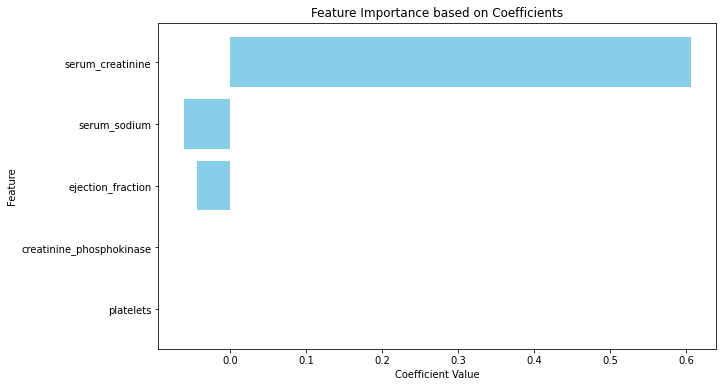

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the coefficients from the model
coefficients = model.coefficients.toArray()

# Create a DataFrame to display features and their corresponding coefficients
feature_importance = pd.DataFrame({"Feature": ["creatinine_phosphokinase", 
                                               "ejection_fraction", 
                                               "platelets", 
                                               "serum_creatinine", 
                                               "serum_sodium"], 
                                   "Coefficient": coefficients})

# Sort the features based on the absolute value of coefficients
feature_importance = feature_importance.sort_values(by="Coefficient", key=abs, ascending=False)
print(feature_importance)

# Visualize the importance of features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Coefficient"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance based on Coefficients')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [7]:
# Stop Spark session
spark.stop()